In [11]:
from data_loaders import load_data_labels_based_on_dataset
from share import datasets_basic_infos
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper
from data_utils import train_test_val_split
from pathlib import Path

ROOT_VOTING_SYSTEM_PATH: str = "/Users/rosit/Documents/workprojects/bci_complete/voting_system_platform"


dataset_name = 'torres'  # Only two things I should be able to change

# Folders and paths
dataset_foldername = dataset_name + '_dataset'
computer_root_path = str(ROOT_VOTING_SYSTEM_PATH) + "/Datasets/"
data_path = computer_root_path + dataset_foldername
dataset_info = datasets_basic_infos[dataset_name]

epochs_list = []
for subject_id in range(dataset_info['subjects']):
    individual_epochs, data, labels = load_data_labels_based_on_dataset(dataset_name, subject_id, data_path)
    epochs_list.append(individual_epochs)

epochs = mne.concatenate_epochs(epochs_list)

data_train, data_test, _, labels_train, labels_test, _ = train_test_val_split(
        dataX=data, dataY=labels, valid_flag=False)

Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
924 matching events found
No baseline correction applied


Delta Waves (0.5–4 Hz)
Theta Waves (4–8 Hz)
Alpha Waves (8–12.5 Hz)
Beta Waves (12.5–30 Hz)
        Low Beta Waves (Beta 1): Frequencies range from 12.5 Hz to 16 Hz.
        Beta Waves (Beta 2): Frequencies span from 16.5 Hz to 20 Hz.
        High Beta Waves (Beta 3): Frequencies fall between 20.5 Hz and 29 Hz
Gamma Waves (30–80 Hz)

In [12]:
freqs = np.arange(0.5, 4)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (0, 1.4)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

tmin, tmax = -1, 4
#event_ids = {"OVTK_StimulationId_Number_01":0, "OVTK_StimulationId_Number_02":1, "OVTK_StimulationId_Number_03":2, "OVTK_StimulationId_Number_04":3}  # map event IDs to tasks
#event_ids = {"OVTK_StimulationId_Label_01":0, "OVTK_StimulationId_Label_02":1, "OVTK_StimulationId_Label_03":2, "OVTK_StimulationId_Label_04":3}  # map event IDs to tasks
event_ids = {"Arriba":0, "Abajo":1, "Izquierda":2, "Derecha":3}  # map event IDs to tasks

In [13]:
tfr = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)

Not setting metadata


In [15]:
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

Applying baseline correction (mode: percent)


C:\Users\rosit\AppData\Local\Temp\ipykernel_25800\2267037763.py:1: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmin (0 s)
  tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
C:\Users\rosit\AppData\Local\Temp\ipykernel_25800\2267037763.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (3.28125 s)
  tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
C:\Users\rosit\Documents\workprojects\bci_complete\venv_bci\lib\site-packages\mne\baseline.py:122: RuntimeWarning: divide by zero encountered in divide
  d /= m


ValueError: Expected the given number of width ratios to match the number of columns of the grid

<Figure size 1200x400 with 0 Axes>

In [8]:
df = tfr.to_data_frame(time_format=None)
df.head()

,time,freq,epoch,condition,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000000,2.0,0,Arriba,1.515954,1.521964,1.517778,1.519403,1.523545,1.523021,1.518798,1.514653,1.521875,1.523947,1.521672,1.520124,1.513766,1.516294
1,0.015625,2.0,0,Arriba,1.509347,1.515108,1.510931,1.512493,1.516520,1.515643,1.511519,1.507828,1.514671,1.517261,1.514932,1.513195,1.507011,1.509513
2,0.031250,2.0,0,Arriba,1.480869,1.486401,1.482215,1.483690,1.487522,1.486272,1.482270,1.479038,1.485423,1.488517,1.486223,1.484388,1.478240,1.480921
3,0.046875,2.0,0,Arriba,1.433500,1.438779,1.434552,1.435952,1.439492,1.437862,1.434022,1.431177,1.437096,1.440676,1.438450,1.436614,1.430389,1.433438
4,0.062500,2.0,0,Arriba,1.371794,1.376874,1.372576,1.373937,1.377201,1.375135,1.371502,1.369094,1.374505,1.378406,1.376302,1.374552,1.368102,1.371709


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


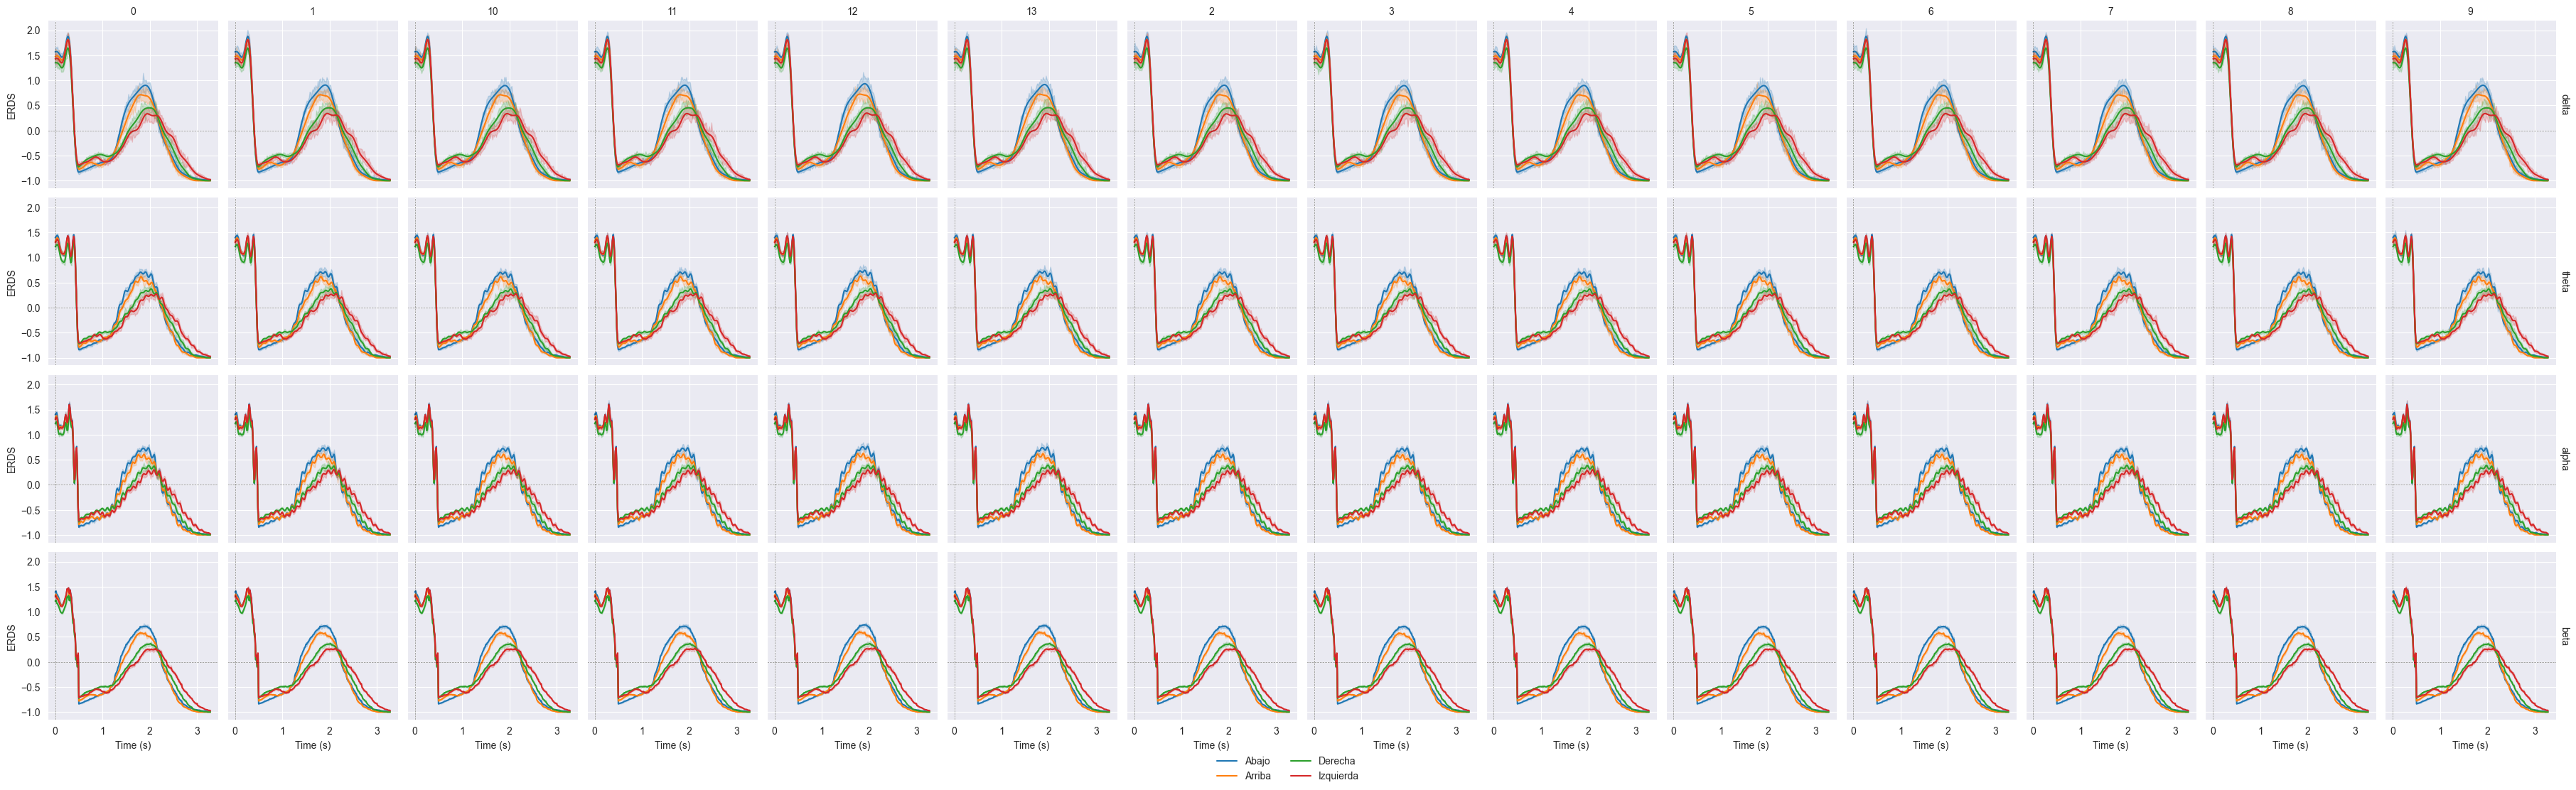

In [9]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
#df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
#g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

C:\Users\rosit\Documents\workprojects\bci_complete\venv_bci\lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


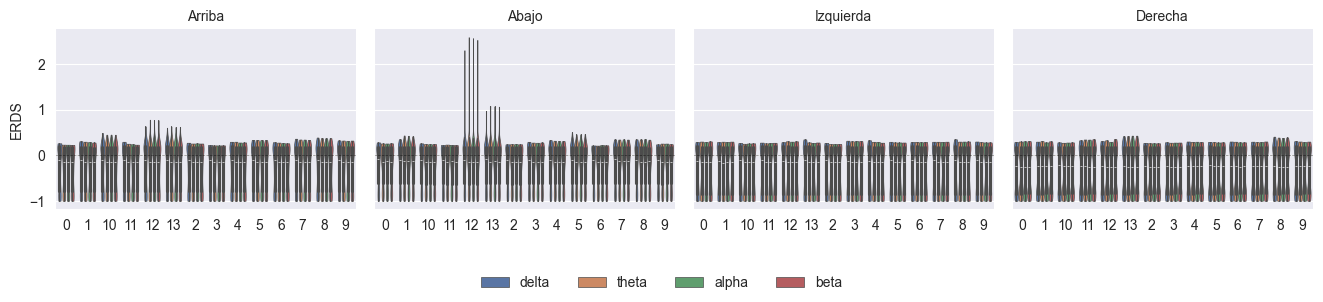

In [10]:
df_mean = (
    df.query("time > 1")
    .groupby(["condition", "epoch", "band", "channel"], observed=False)[["value"]]
    .mean()
    .reset_index()
)

g = sns.FacetGrid(
    df_mean, col="condition", col_order=list(event_ids.keys()), margin_titles=True
)
g = g.map(
    sns.violinplot,
    "channel",
    "value",
    "band",
    cut=0,
    palette="deep",
    hue_order=freq_bands_of_interest,
    linewidth=0.5,
).add_legend(ncol=4, loc="lower center")

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)